# 教師なし異常検知

## おおまかな流れ

    1. 正常時データの振る舞いのパターンを発見
    
    2. 上記から正常・異常の境目となる閾値を設定
    
    3. 観測データから閾値を超えたら異常発生と判断

## 使用するデータ

- 50個の正常なFPGA ＋ 2個の経年劣化させたFPGA 

    - FPGAは，4884の特徴量（周波数）を持つ
    
    - なお，測定値が0の部分は考慮しない (FPGAの構造上必ず生じる）
    
---------------------------------------------------------------

    
## 今回の実験

- 残差データ

    - 前回同様，残差データを利用して実験する．
    
    - 残差は,「元の測定値 - 推定値」と定義する．
    
    - 推定値は,「上下左右データの平均値」と「周囲８個のデータの平均値」の2種類定義する．
      (なお，「四隅，縁」は前回と同様とする）


- 教師なし異常検知アルゴリズム

    - ホテリング理論
    
    - IsolationForest
    
    - Kmeans++
　
--------------------------------------------------------------------------

## まずは必要な関数を定義する

In [46]:
"""ライブラリ"""
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from statistics import mean, variance
from scipy import stats
from scipy.stats import norm
from collections import Counter
import copy


"""データ生成関数"""
def generate_data(directory, data_n, aged_data_n):
    data = []
    aged_data = []
    
    for i in range(1, data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'.csv', header=None).values
        data.append(tmp_data)
    
    for i in range(1, aged_data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'_aged.csv', header=None).values
        aged_data.append(tmp_data)
    
    data = np.array(data)
    aged_data = np.array(aged_data)
    
    return data, aged_data

newdata, ageddata = generate_data('fresh_aged_ieice', 50, 2)


"""0の数数える関数 二次元入れろ"""
def count_zero(data):
    
    tmp = []
    for i in range(data.shape[0]):
        a = (data[i].shape[0] * data[i].shape[1]) - np.count_nonzero(data[i])
        tmp.append(a)
        
    return tmp


"""一次元にする関数"""
def change_flatten(data):
    tmp = []
    for i in range(data.shape[0]):
        tmp.append(data[i].flatten())
        
    tmp = np.array(tmp)
    
    return tmp


"""0を消す関数 flatteしたやつ入れろ"""
def delete_zero(data):
    tmp = []
    for i in range(data.shape[0]):
        tmp2 = copy.deepcopy(data[i])
        tmp.append(tmp2[tmp2 != 0])
        
    tmp = np.array(tmp)
    
    return tmp

"""９２０この値を消す"""
def delete_920(data, check):
    new = np.zeros_like(data)
    counter = 0
    for i in data:
        for j in range(i.shape[0]):
            for k in range(i.shape[1]):
                if [j, k] in check:
                    new[counter, j, k] = 0 
                else:
                    new[counter, j, k] = data[counter, j, k]
                    
        counter += 1
                    
    return new
                    

"""東西南北残差作り出す関数"""
def EWSN_residual(data):
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(4):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = data[i, j, k] - data_mean

    return residual_data


"""king残差作り出す関数"""
def king_residual(data):
    tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
    tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
    
    residual_data = np.zeros_like(data)
    
    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(8):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = data[i, j, k] - data_mean

    return residual_data


"""確率密度関数の可視化"""
def plot_new(data):
    y = 11
    x = 5
    fig,ax = plt.subplots(y,x,figsize=(30,30))
    count = 0
    for i in range(y):
        for j in range(x):
            if count >= 52:
                break
            dummy = sns.distplot(data[count], ax=ax[i, j])
            count += 1
        if count >= 52:
            break
    
    plt.show()

    
"""リストを繋げる関数"""
def connect(a, b):
    tmp = []
    for i in range(a.shape[0]):
        tmp.append(a[i])
        
    for i in range(b.shape[0]):
        tmp.append(b[i])
    
    tmp = np.array(tmp)
    return tmp


"""QQプロット出力する関数"""
def qq(x):
    stats.probplot(x, dist="norm", plot=plt)  #QQプロット表示
    plt.show()

    
"""コルモゴロフスミルノフ検定する関数"""
def kolmogorov_smirnov(x):
    loc, scale = norm.fit(x)
    n = norm(loc=loc, scale=scale)  # create a normal distribution with loc and scale
    p = stats.kstest(x, n.cdf).pvalue  #コルモゴロフスミルノフ検定
    return p


"""シャピロウィルク検定する関数"""
def shapiro_wilk(x):
    p=stats.shapiro(x)[1]  #シャピロウィルク検定
    return p


"""合計値と平均出す関数 一次元混合データが望ましい"""
def summean_residual(data):
    tmpsum = []
    tmpmean = []
    for i in range(data.shape[0]):
        tmpsum.append(data[i].sum())
        tmpmean.append(mean(data[i]))
        
    tmpsum = np.array(tmpsum)
    tmpmean = np.array(tmpmean)
    
    return tmpsum, tmpmean


"""散布図"""
def ten(data):
    x = np.arange(1, 53)
    plt.scatter(x, data)
    plt.title("scatter")
    plt.xlabel("sample number")
    plt.ylabel("residual")
    plt.grid(True)
    plt.show()

    
"""ホテリング理論"""
def hoteling(data):
    # 標本平均
    mn = mean(data)
    
    # 標本分散
    vari = variance(data)
    
    # 異常度
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - mn)**2 / vari
        anomaly_scores.append(anomaly_score)
    
    # カイ二乗分布による5%水準の閾値
    threshold = stats.chi2.interval(0.95, 1)[1]
    
    # 結果の描画
    print('ホテリング理論結果')
    num = np.arange(1, 53)
    plt.plot(num, anomaly_scores, "o", color = "b")
    plt.plot([0,53],[threshold, threshold], 'k-', color = "r", ls = "dashed")
    plt.xlabel("Sample number")
    plt.ylabel("Anomaly score")
    plt.show()
    
    X = pd.DataFrame({"data": data})
    anomaly_scores_col = pd.DataFrame({"anomaly_score": anomaly_scores})
    X = pd.concat([X, anomaly_scores_col], axis=1)

    # 外れ値検知する
    normality = X[X["anomaly_score"] < threshold]
    outliers = X[threshold <= X["anomaly_score"]]

    # 正常値と外れ値をプロット
    print('散布図')
    plt.scatter(normality.index, normality["data"], label="normality")
    plt.scatter(outliers.index, outliers["data"], c="red", label="outlier")
    plt.ylabel("value")
    plt.legend()
    plt.show()
    
    for i, j in enumerate(anomaly_scores):
        if j >= threshold:
            print(f'異常index：{i+1}')
            
    print()

## 可視化

- 次に0を抜いたデータをsns.distplotで可視化する．

- distplotはx軸はデータの値，y軸はその密度を示す

In [49]:
fresh, aged = generate_data('fresh_aged_ieice', 50, 2) # (50, 148, 33) (2, 148, 33)

newdata = connect(fresh, aged) # (52, 148, 33)
check_FPGA = []
for i in range(148):
    for j in range(33):
        if fresh[0, i, j] == 0:
            check_FPGA.append([i,j])
freshaged = delete_920(newdata, check_FPGA) #(52, 148, 33)

flat_freshaged = change_flatten(newdata) # (52, 4884)
new_freshaged = change_flatten(freshaged) # (52 4884)

new_nonzero = delete_zero(flat_freshaged) #(52, 3964前後)
nonzero_freshaged = delete_zero(new_freshaged) #(52, 3964)

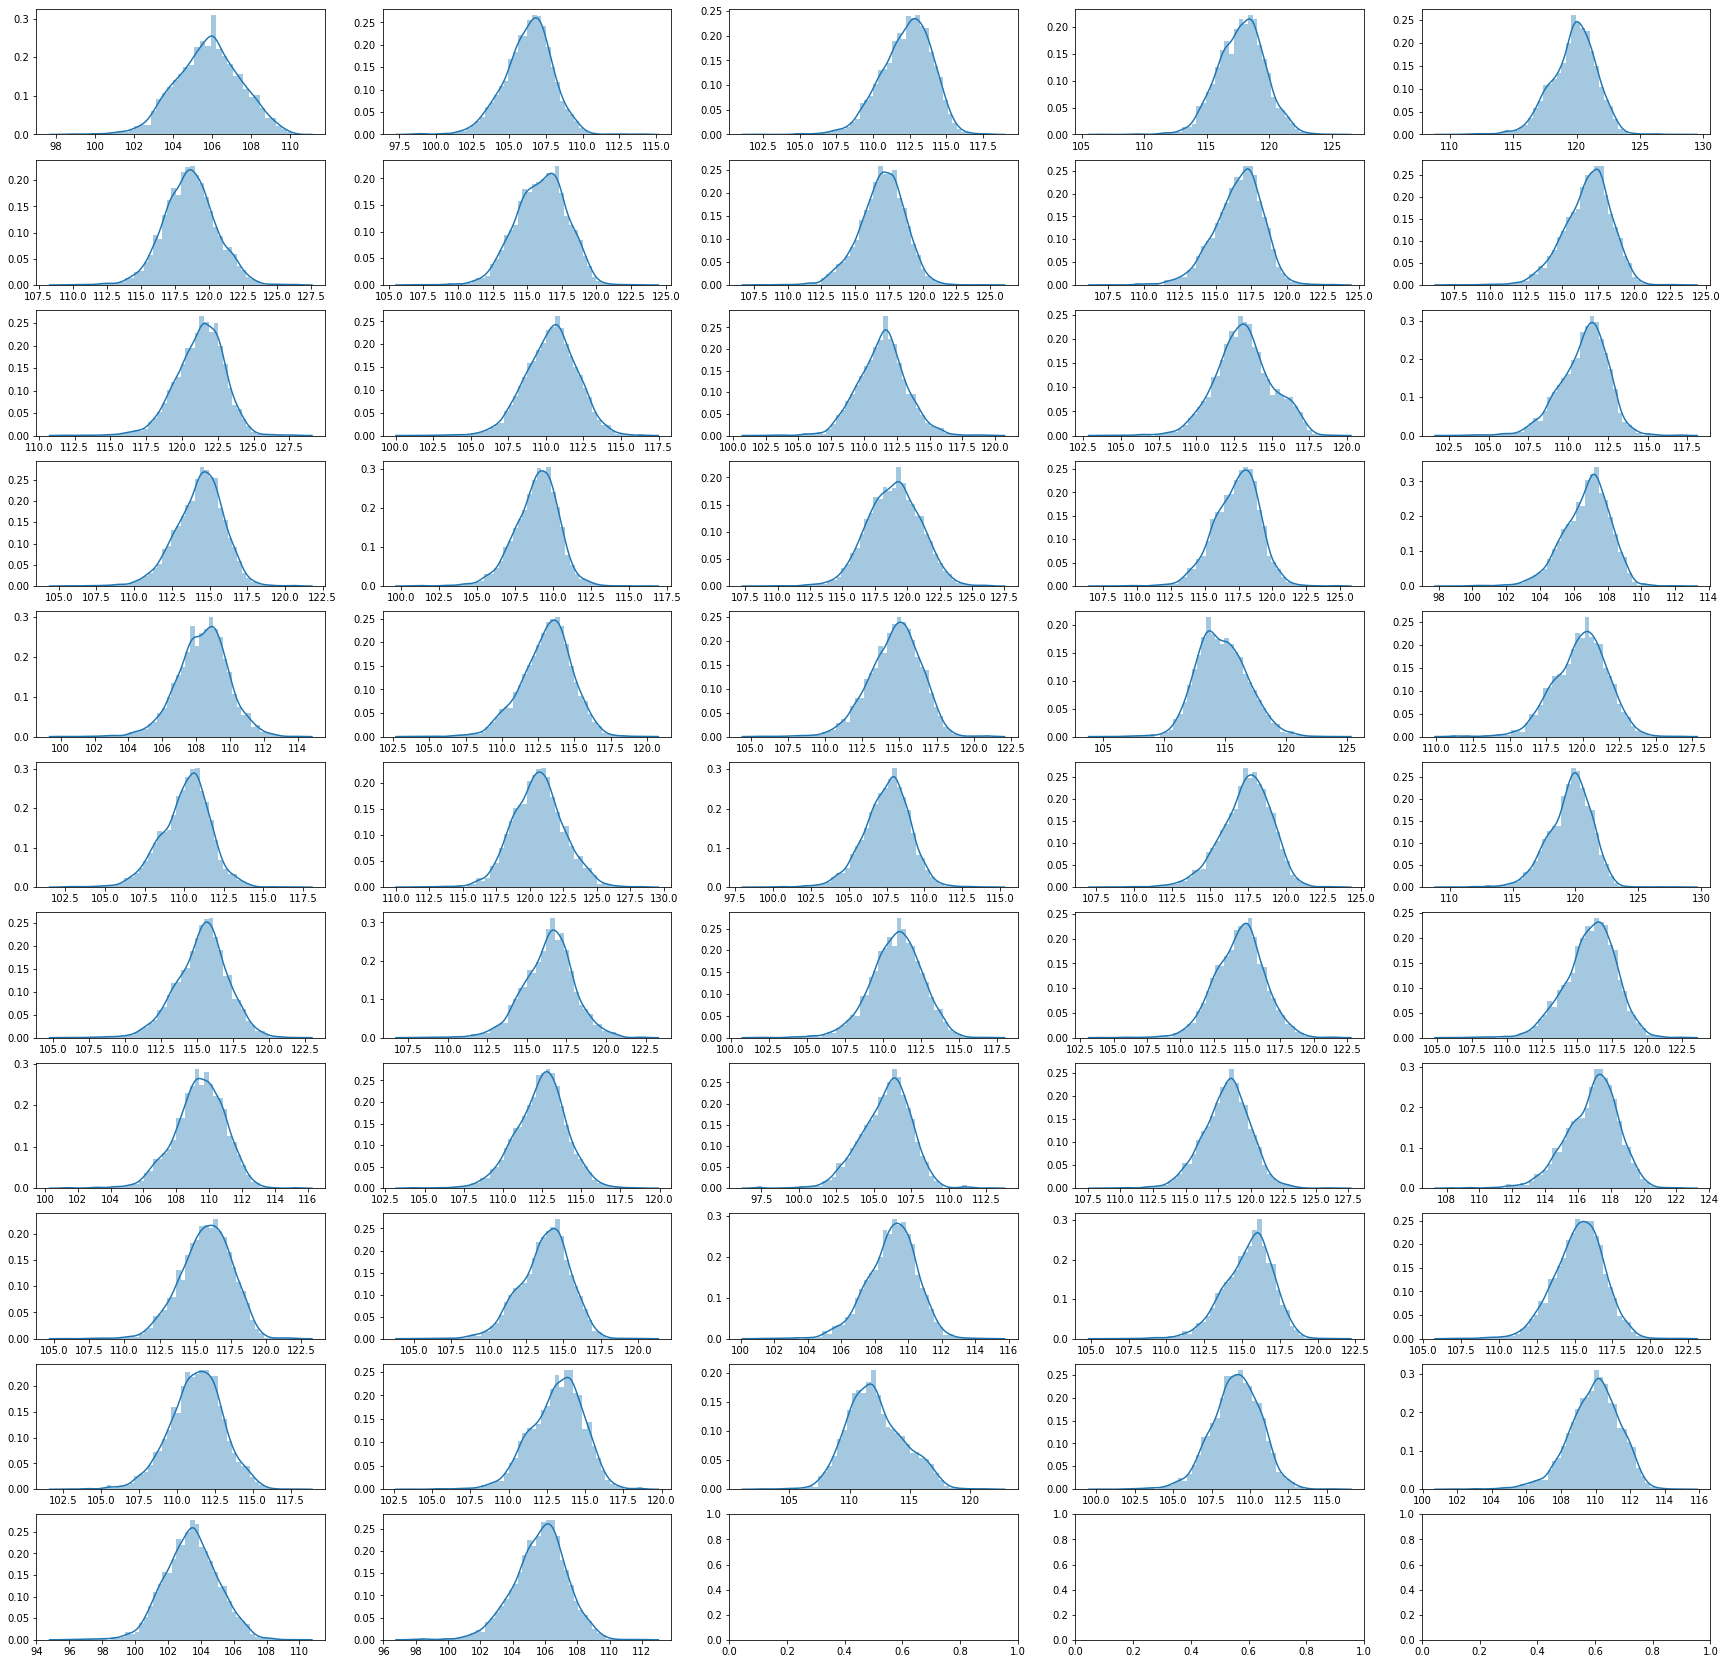

In [50]:
plot_new(nonzero_freshaged)

## 全てのFPGAが正規分布に従っているように見える

----------------------------------------------------------------

# 正規性の検定
    正規分布しているかどうかの確認
    
## QQプロット

    - QQプロットとは、X軸上に観測した累積パーセント、Y軸上に期待累積パーセントを持つグラフ
    
    - 一直線上になっていれば正規分布
    
    
## コルモゴロフスミルノフ検定 (KS検定）
## シャピロウィルク検定

    - 得られたデータが正規分布に従うものか否かを調べる検定法.
    
    - すなわち，データが正規母集団に由来するという帰無仮説を検定する.
    
    
- データの分布が仮定した分布と一致するかを調べる


- データが正規分布であるという帰無仮説を立てる


- 帰無仮説「データの分布が仮定した分布に一致している」を棄却できるかどうか

  -> 棄却できないからといって，正規分布と一致しているわけではない
  
    
- p値が0.05以下の場合は棄却する(つまりp値が0.05以上なら正規分布)

fresh
QQプロット


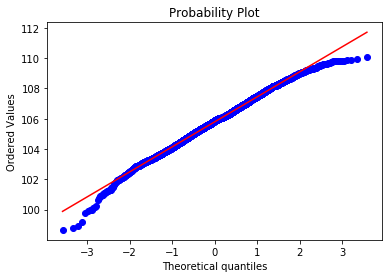

コルモゴロフスミルノフ検定0.17664074847314698
シャピロウィルク検定4.284796961684378e-09

QQプロット


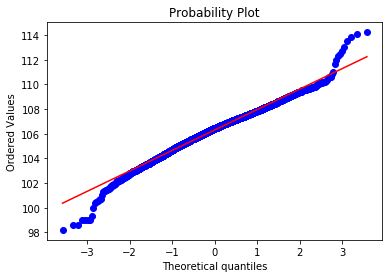

コルモゴロフスミルノフ検定7.78987420010969e-05
シャピロウィルク検定7.951204361789677e-19

QQプロット


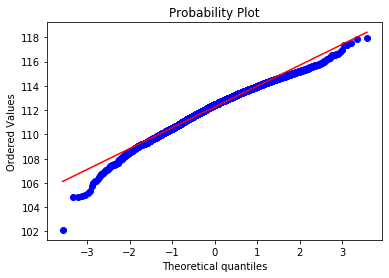

コルモゴロフスミルノフ検定9.001053222443759e-07
シャピロウィルク検定4.22764030075411e-20

QQプロット


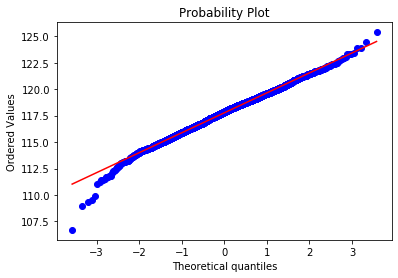

コルモゴロフスミルノフ検定0.014580104332488901
シャピロウィルク検定3.0700930686577976e-10

QQプロット


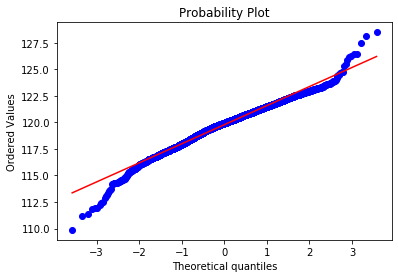

コルモゴロフスミルノフ検定1.0382481635824987e-08
シャピロウィルク検定5.048197248396248e-21

---------------------------------------------
aged
QQプロット


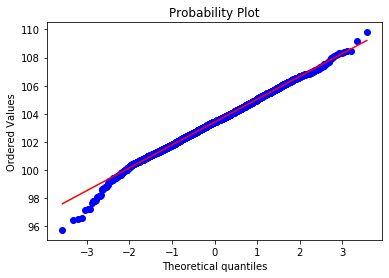

コルモゴロフスミルノフ検定0.5156782058868354
シャピロウィルク検定4.7392410351676517e-07

QQプロット


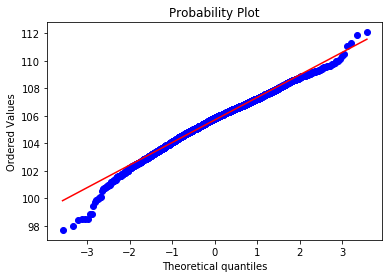

コルモゴロフスミルノフ検定0.00011315372252185875
シャピロウィルク検定1.5443250278128213e-16



In [51]:
print('fresh')
for i in range(5):
    print('QQプロット')
    qq(nonzero_freshaged[i])
    a = kolmogorov_smirnov(nonzero_freshaged[i])
    b = shapiro_wilk(nonzero_freshaged[i])
    
    print(f'コルモゴロフスミルノフ検定{a}')
    print(f'シャピロウィルク検定{b}')
    print()

print('---------------------------------------------')
    
print('aged')
for i in range(50, 52):
    print('QQプロット')
    qq(nonzero_freshaged[i])
    a = kolmogorov_smirnov(nonzero_freshaged[i])
    b = shapiro_wilk(nonzero_freshaged[i])
    
    print(f'コルモゴロフスミルノフ検定{a}')
    print(f'シャピロウィルク検定{b}')
    print()

In [52]:
count_kol = 0
count_sha = 0
for i in nonzero_freshaged:
    a = kolmogorov_smirnov(i)
    b = shapiro_wilk(i)
    
    if a >= 0.05:
        count_kol += 1
    if b >= 0.05:
        count_sha += 1

print('棄却できなかった数')
print()
print('コルモゴロフスミルノフ検定')
print(count_kol)
print('シャピロウィルク検定')
print(count_sha)

棄却できなかった数

コルモゴロフスミルノフ検定
5
シャピロウィルク検定
0


## 検定結果
- FPGAの測定値は正規分布に従っているとはいえない．

---------------------------------------

## 残差データを調べてみる
    今回は残差データが2種類ある．
    
    - 上下左右四方向を推定値として利用
    - 周囲八方向を推定値として利用

-----------------------------------------

- sns.distplotで可視化する．

- distplotはx軸はデータの値，y軸はその密度を示す

In [53]:
resi_1 = EWSN_residual(freshaged) # (52, 148, 33)
resi_2 = king_residual(freshaged) # (52, 148, 33)

flat_resi_1 = change_flatten(resi_1)
flat_resi_2 = change_flatten(resi_2)

nonzero_resi_1 = delete_zero(flat_resi_1)
nonzero_resi_2 = delete_zero(flat_resi_2)

四方向


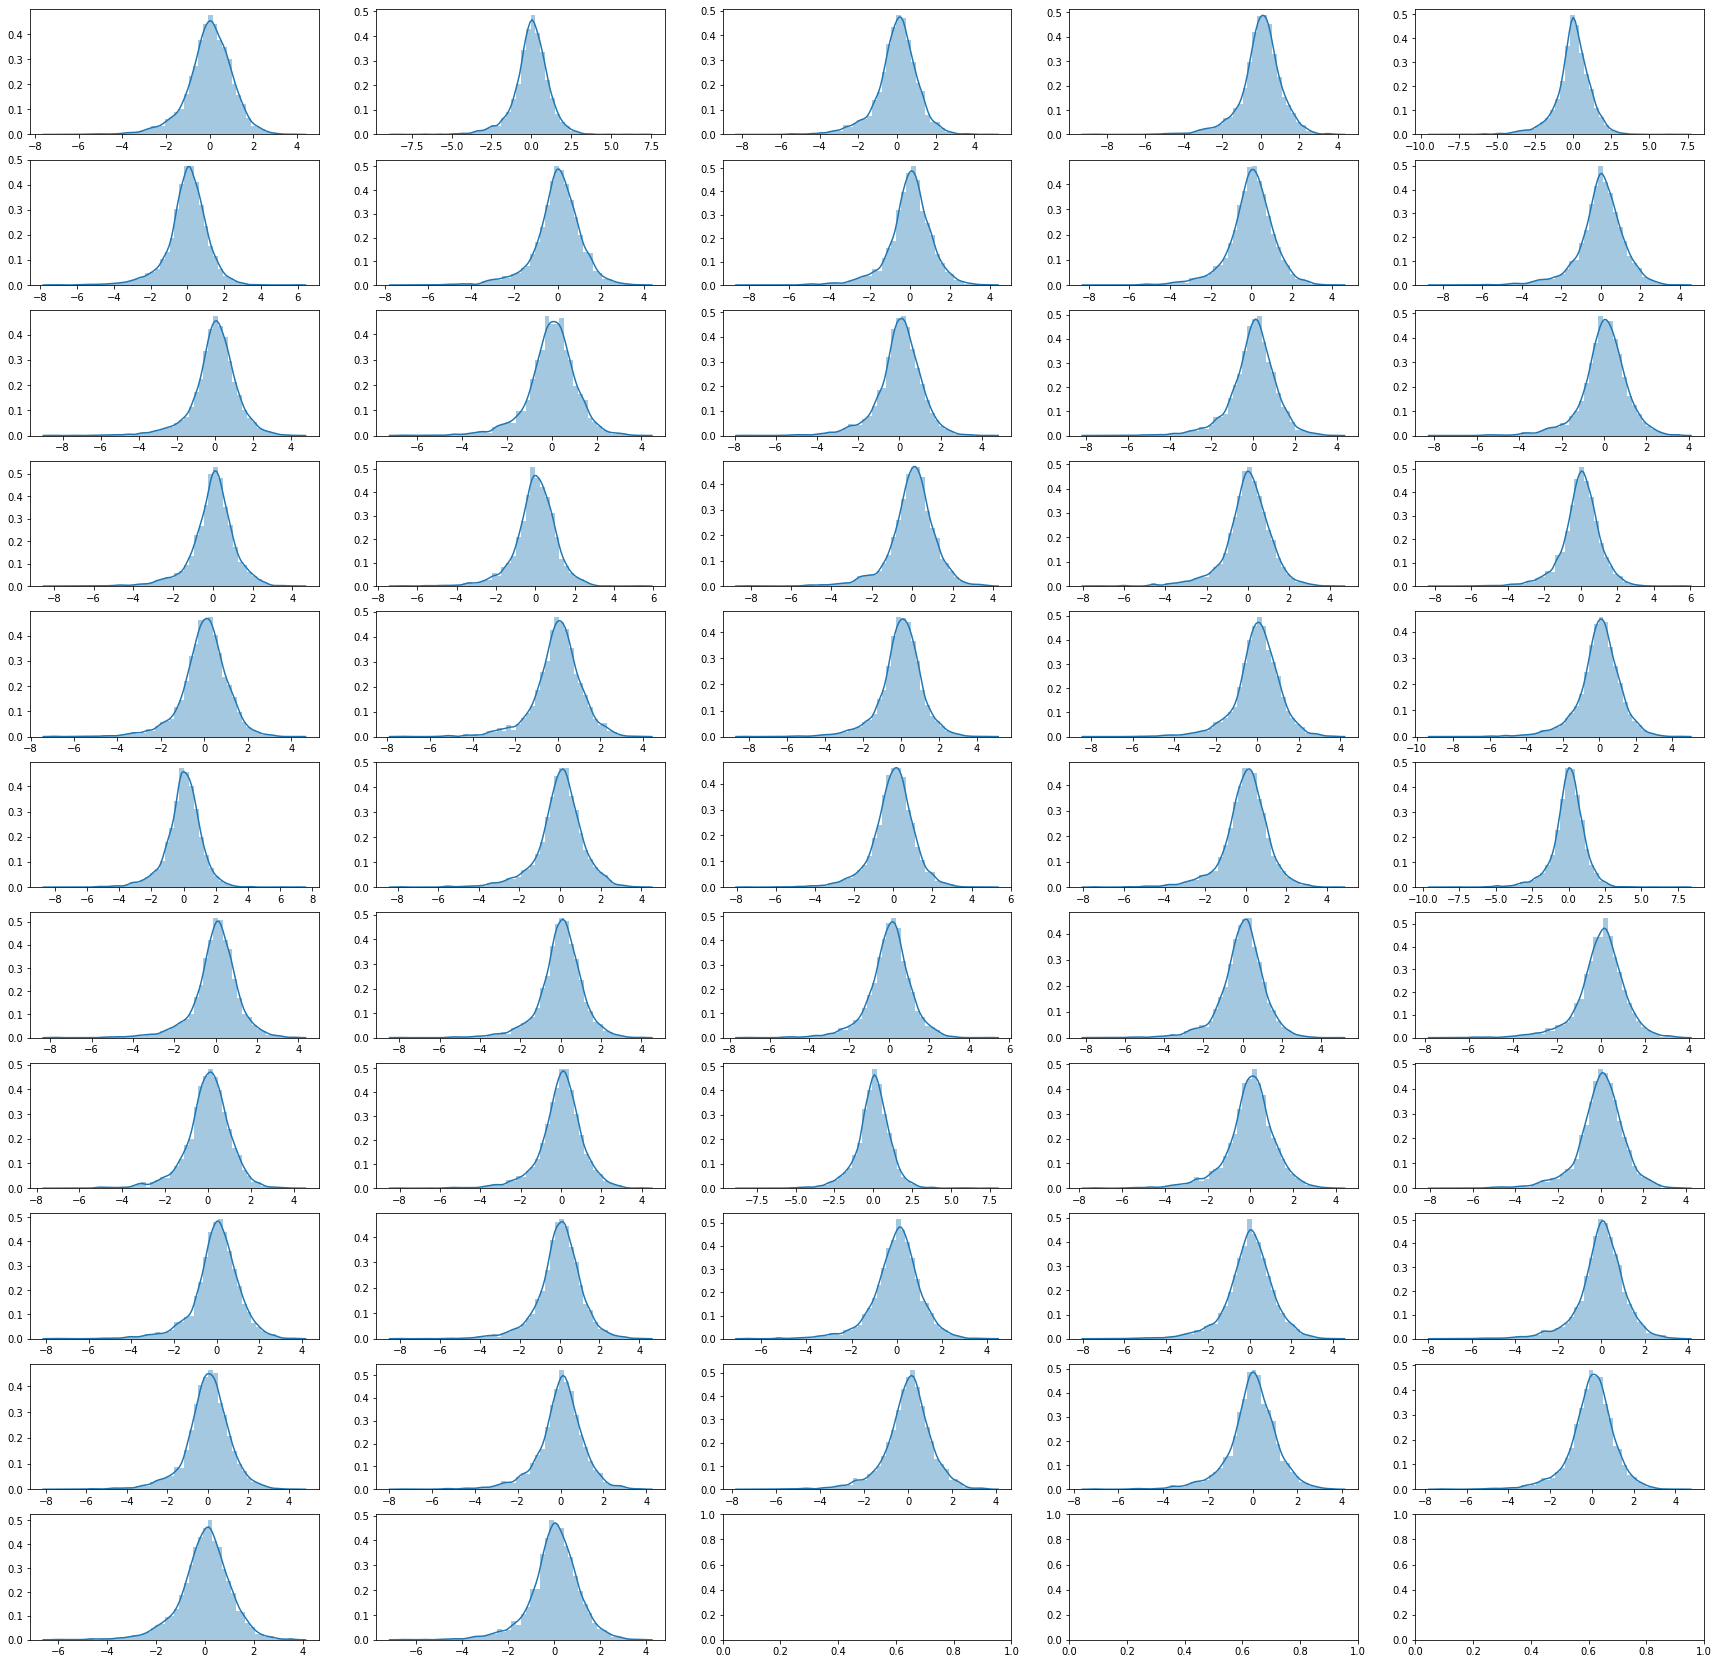

八方向


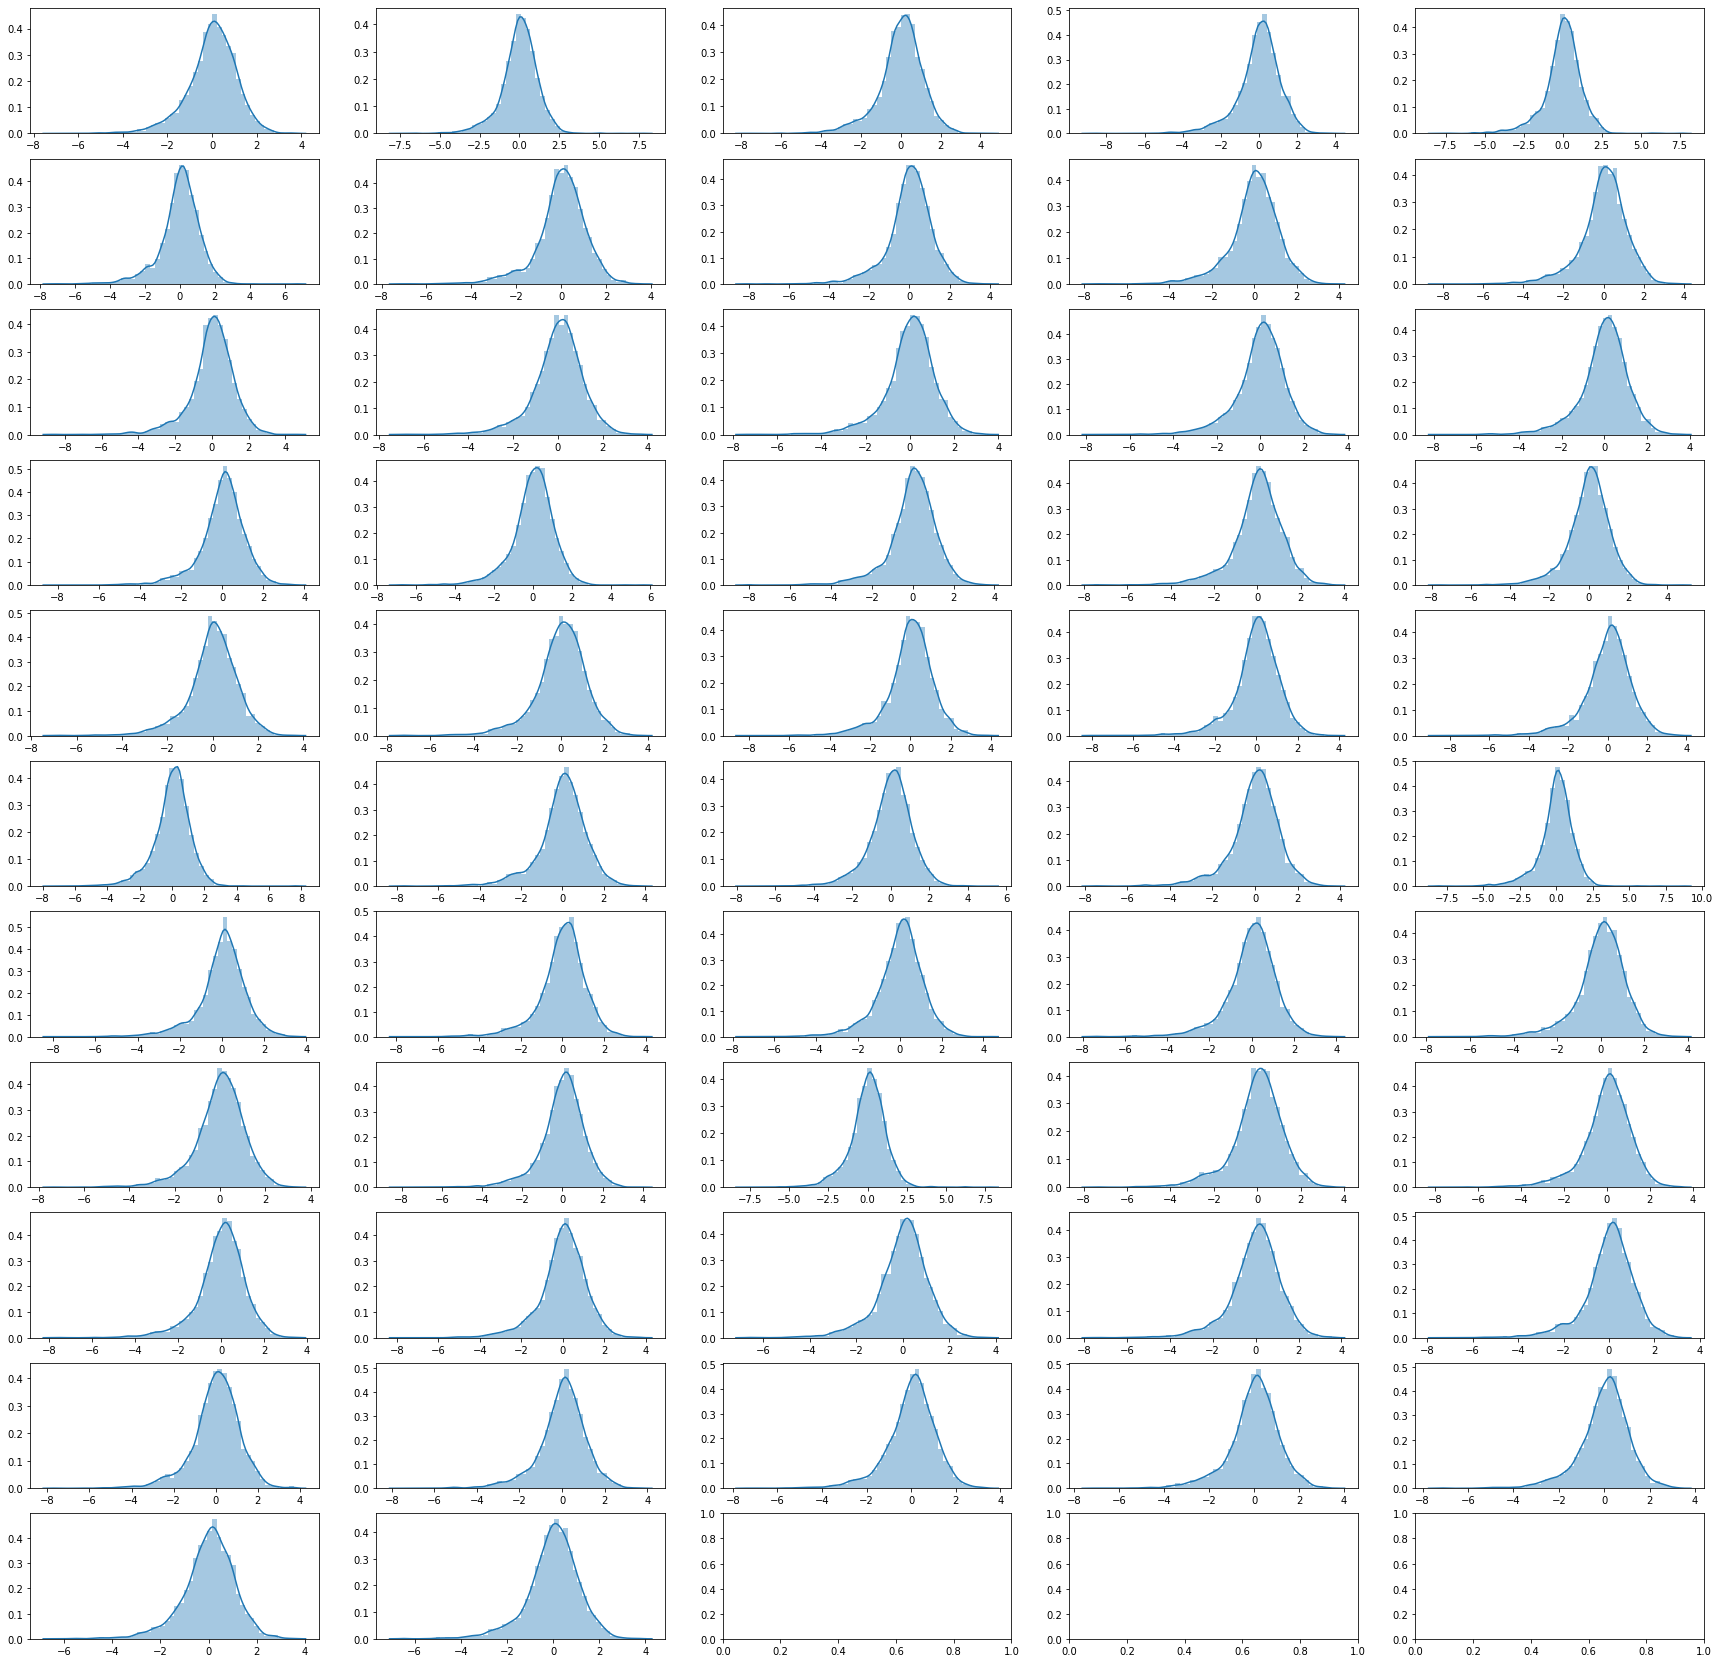

In [54]:
print('四方向')
plot_new(nonzero_resi_1)

print('八方向')
plot_new(nonzero_resi_2)

## 四方向，八方向とも正規分布に従っているように見える

----------------------------------------------------------------

## 正規性の検定
    
### ・QQプロット
### ・コルモゴロフスミルノフ検定 (KS検定）
### ・シャピロウィルク検定

### fresh2個　aged2個

四方向
fresh
QQプロット


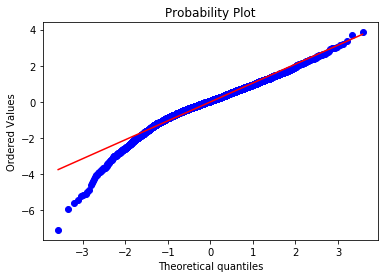

コルモゴロフスミルノフ検定1.080195720317766e-12
シャピロウィルク検定1.757709142004902e-29

QQプロット


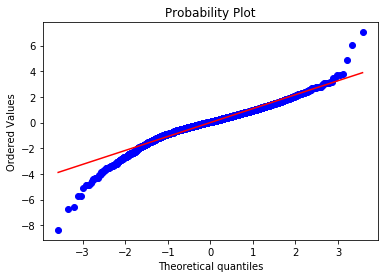

コルモゴロフスミルノフ検定5.9398790714293964e-18
シャピロウィルク検定5.224794678864686e-33

---------------------------------------------
aged
QQプロット


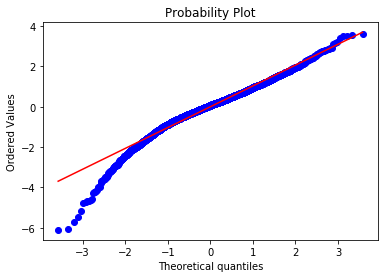

コルモゴロフスミルノフ検定6.6577408551644415e-12
シャピロウィルク検定8.075122728408762e-29

QQプロット


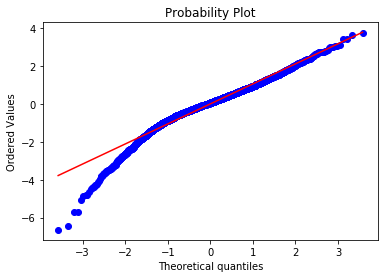

コルモゴロフスミルノフ検定1.3045282312972652e-16
シャピロウィルク検定6.322994927621112e-31

-----------------------------------------------------------
八方向
fresh
QQプロット


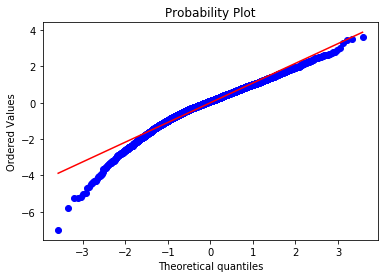

コルモゴロフスミルノフ検定1.998063589575536e-13
シャピロウィルク検定1.8718944890494277e-28

QQプロット


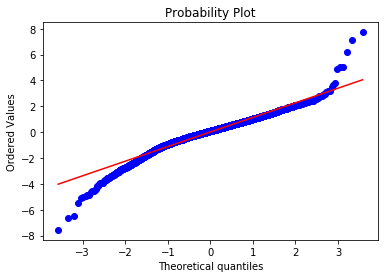

コルモゴロフスミルノフ検定9.267389873171084e-14
シャピロウィルク検定5.564766746905693e-32

---------------------------------------------
aged
QQプロット


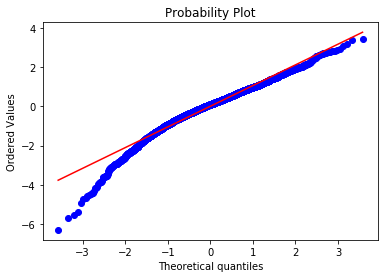

コルモゴロフスミルノフ検定2.7645545775431366e-11
シャピロウィルク検定2.8268891205388206e-28

QQプロット


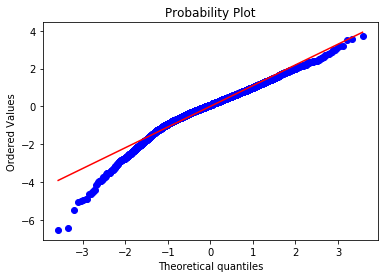

コルモゴロフスミルノフ検定9.22687002846484e-13
シャピロウィルク検定3.679877955859337e-29



In [55]:
print('四方向')
print('fresh')
for i in range(2):
    print('QQプロット')
    qq(nonzero_resi_1[i])
    a = kolmogorov_smirnov(nonzero_resi_1[i])
    b = shapiro_wilk(nonzero_resi_1[i])
    
    print(f'コルモゴロフスミルノフ検定{a}')
    print(f'シャピロウィルク検定{b}')
    print()

print('---------------------------------------------')
    
print('aged')
for i in range(50, 52):
    print('QQプロット')
    qq(nonzero_resi_1[i])
    a = kolmogorov_smirnov(nonzero_resi_1[i])
    b = shapiro_wilk(nonzero_resi_1[i])
    
    print(f'コルモゴロフスミルノフ検定{a}')
    print(f'シャピロウィルク検定{b}')
    print()
    
print('-----------------------------------------------------------')
    
print('八方向')
print('fresh')
for i in range(2):
    print('QQプロット')
    qq(nonzero_resi_2[i])
    a = kolmogorov_smirnov(nonzero_resi_2[i])
    b = shapiro_wilk(nonzero_resi_2[i])
    
    print(f'コルモゴロフスミルノフ検定{a}')
    print(f'シャピロウィルク検定{b}')
    print()

print('---------------------------------------------')
    
print('aged')
for i in range(50, 52):
    print('QQプロット')
    qq(nonzero_resi_2[i])
    a = kolmogorov_smirnov(nonzero_resi_2[i])
    b = shapiro_wilk(nonzero_resi_2[i])
    
    print(f'コルモゴロフスミルノフ検定{a}')
    print(f'シャピロウィルク検定{b}')
    print()

In [56]:
count_kol = 0
count_sha = 0
for i in nonzero_resi_1:
    a = kolmogorov_smirnov(i)
    b = shapiro_wilk(i)
    
    if a >= 0.05:
        count_kol += 1
    if b >= 0.05:
        count_sha += 1

print('四方向棄却できなかった数')
print()

print('コルモゴロフスミルノフ検定')
print(count_kol)
print('シャピロウィルク検定')
print(count_sha)

print('--------------------------------------------')

count_kol = 0
count_sha = 0
for i in nonzero_resi_2:
    a = kolmogorov_smirnov(i)
    b = shapiro_wilk(i)
    
    if a >= 0.05:
        count_kol += 1
    if b >= 0.05:
        count_sha += 1

print('八方向棄却できなかった数')
print()

print('コルモゴロフスミルノフ検定')
print(count_kol)
print('シャピロウィルク検定')
print(count_sha)

四方向棄却できなかった数

コルモゴロフスミルノフ検定
0
シャピロウィルク検定
0
--------------------------------------------
八方向棄却できなかった数

コルモゴロフスミルノフ検定
0
シャピロウィルク検定
0


## 検定結果
- 残差は四方向，八方向ともに正規分布に従っているとはいえない．

## 残差の絶対値

In [57]:
"""東西南北残差作り出す関数"""
def EWSN_residual(data):
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(4):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = np.abs(data[i, j, k] - data_mean)

    return residual_data


"""king残差作り出す関数"""
def king_residual(data):
    tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
    tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
    
    residual_data = np.zeros_like(data)
    
    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(8):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = np.abs(data[i, j, k] - data_mean)

    return residual_data

In [58]:
resi_1 = EWSN_residual(freshaged) # (52, 148, 33)
resi_2 = king_residual(freshaged) # (52, 148, 33)

flat_resi_1 = change_flatten(resi_1)
flat_resi_2 = change_flatten(resi_2)

nonzero_resi_1 = delete_zero(flat_resi_1)
nonzero_resi_2 = delete_zero(flat_resi_2)

四方向


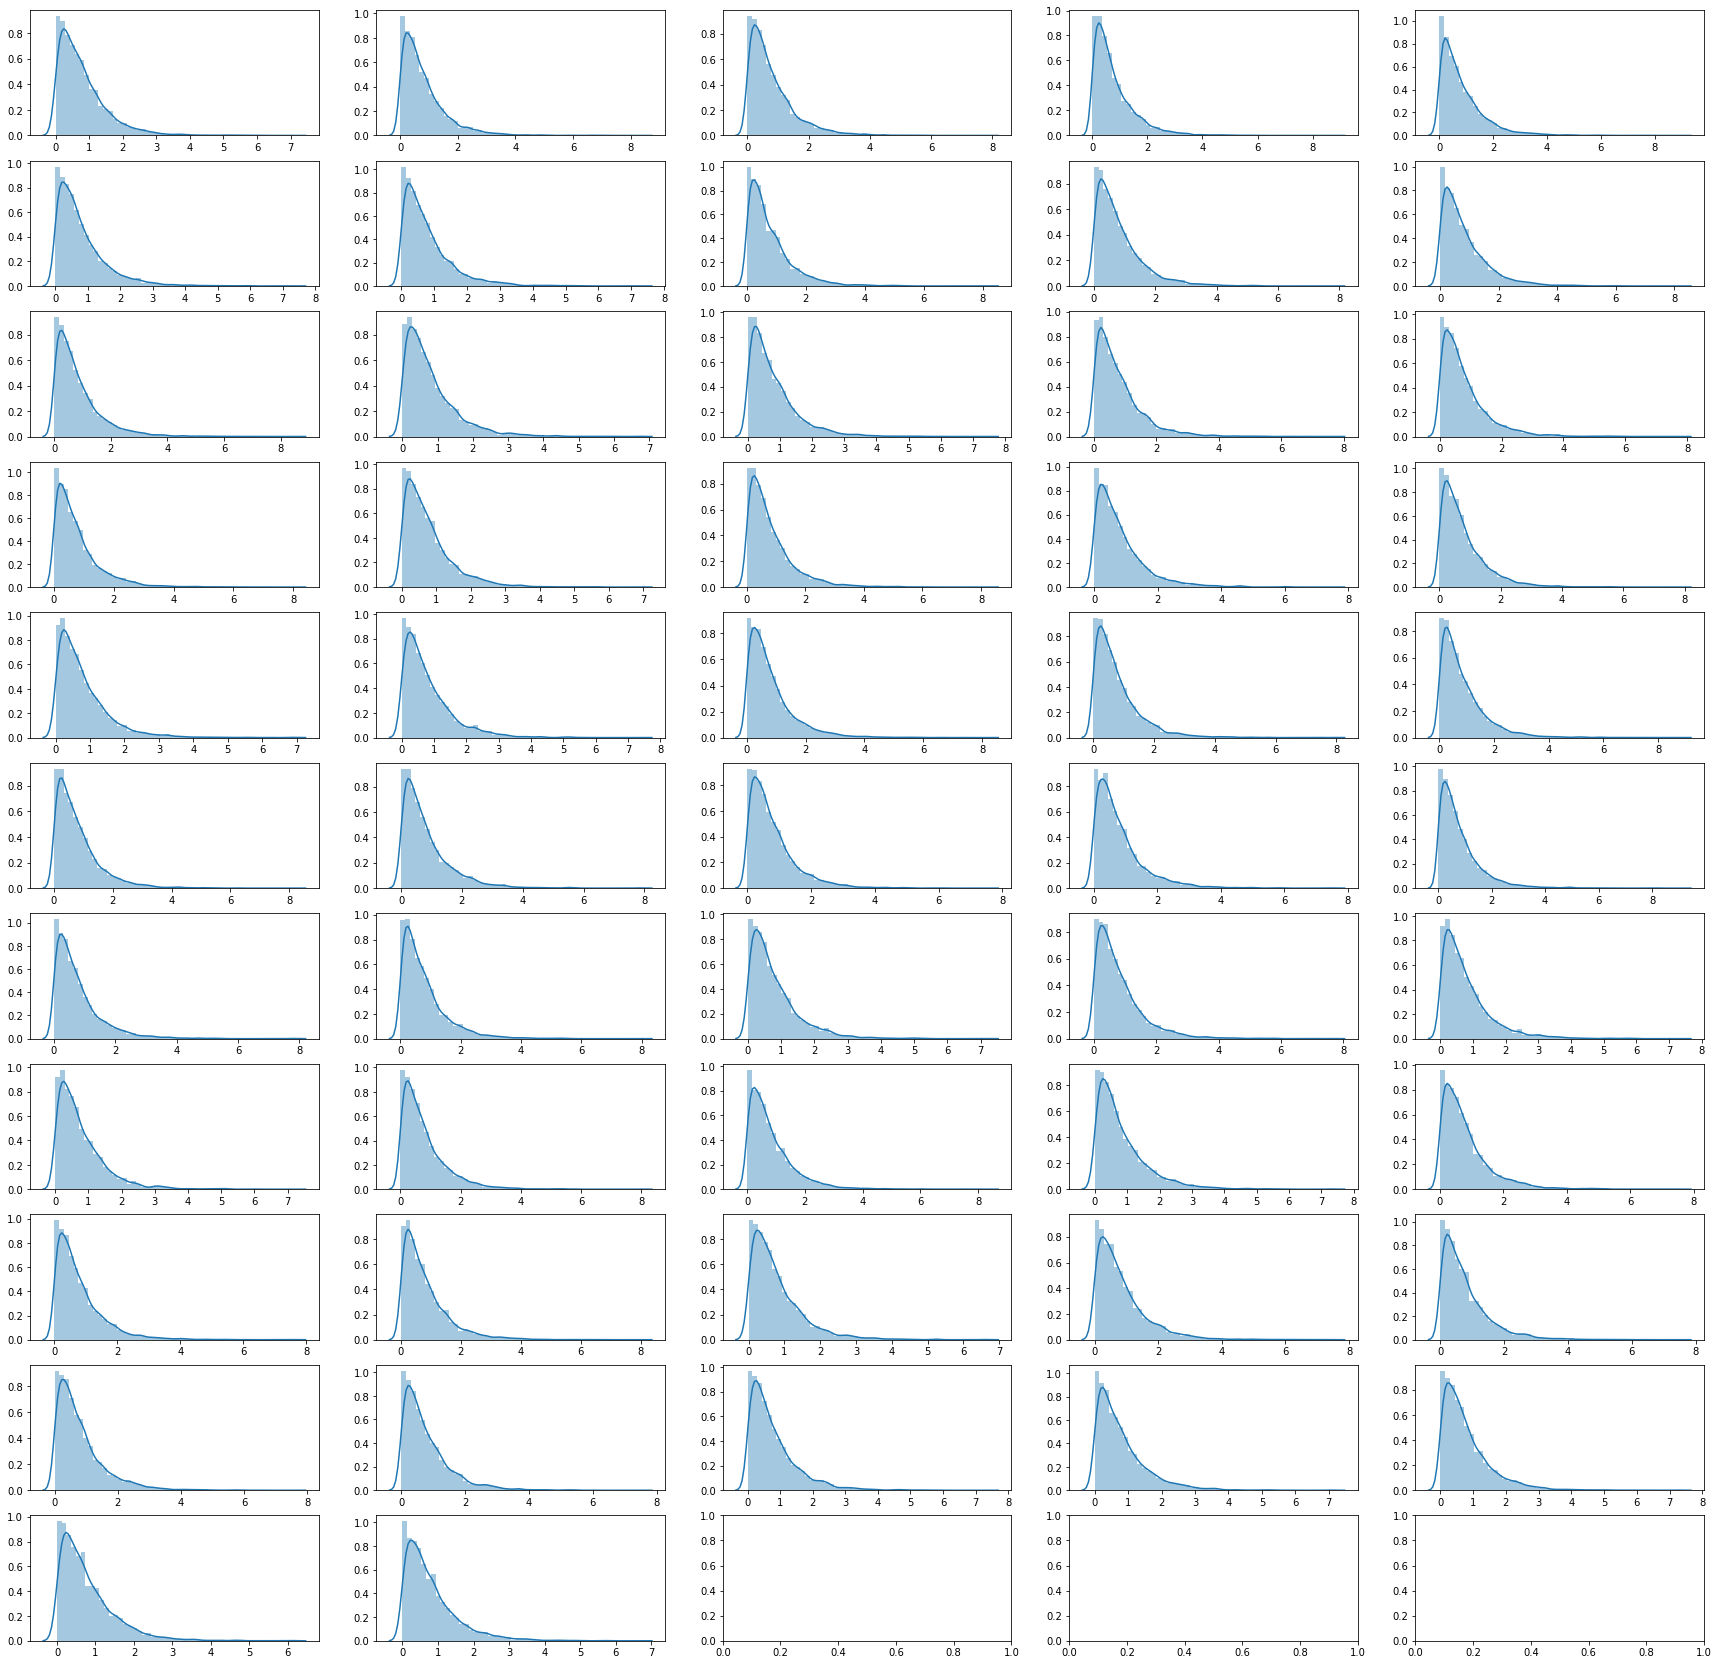

八方向


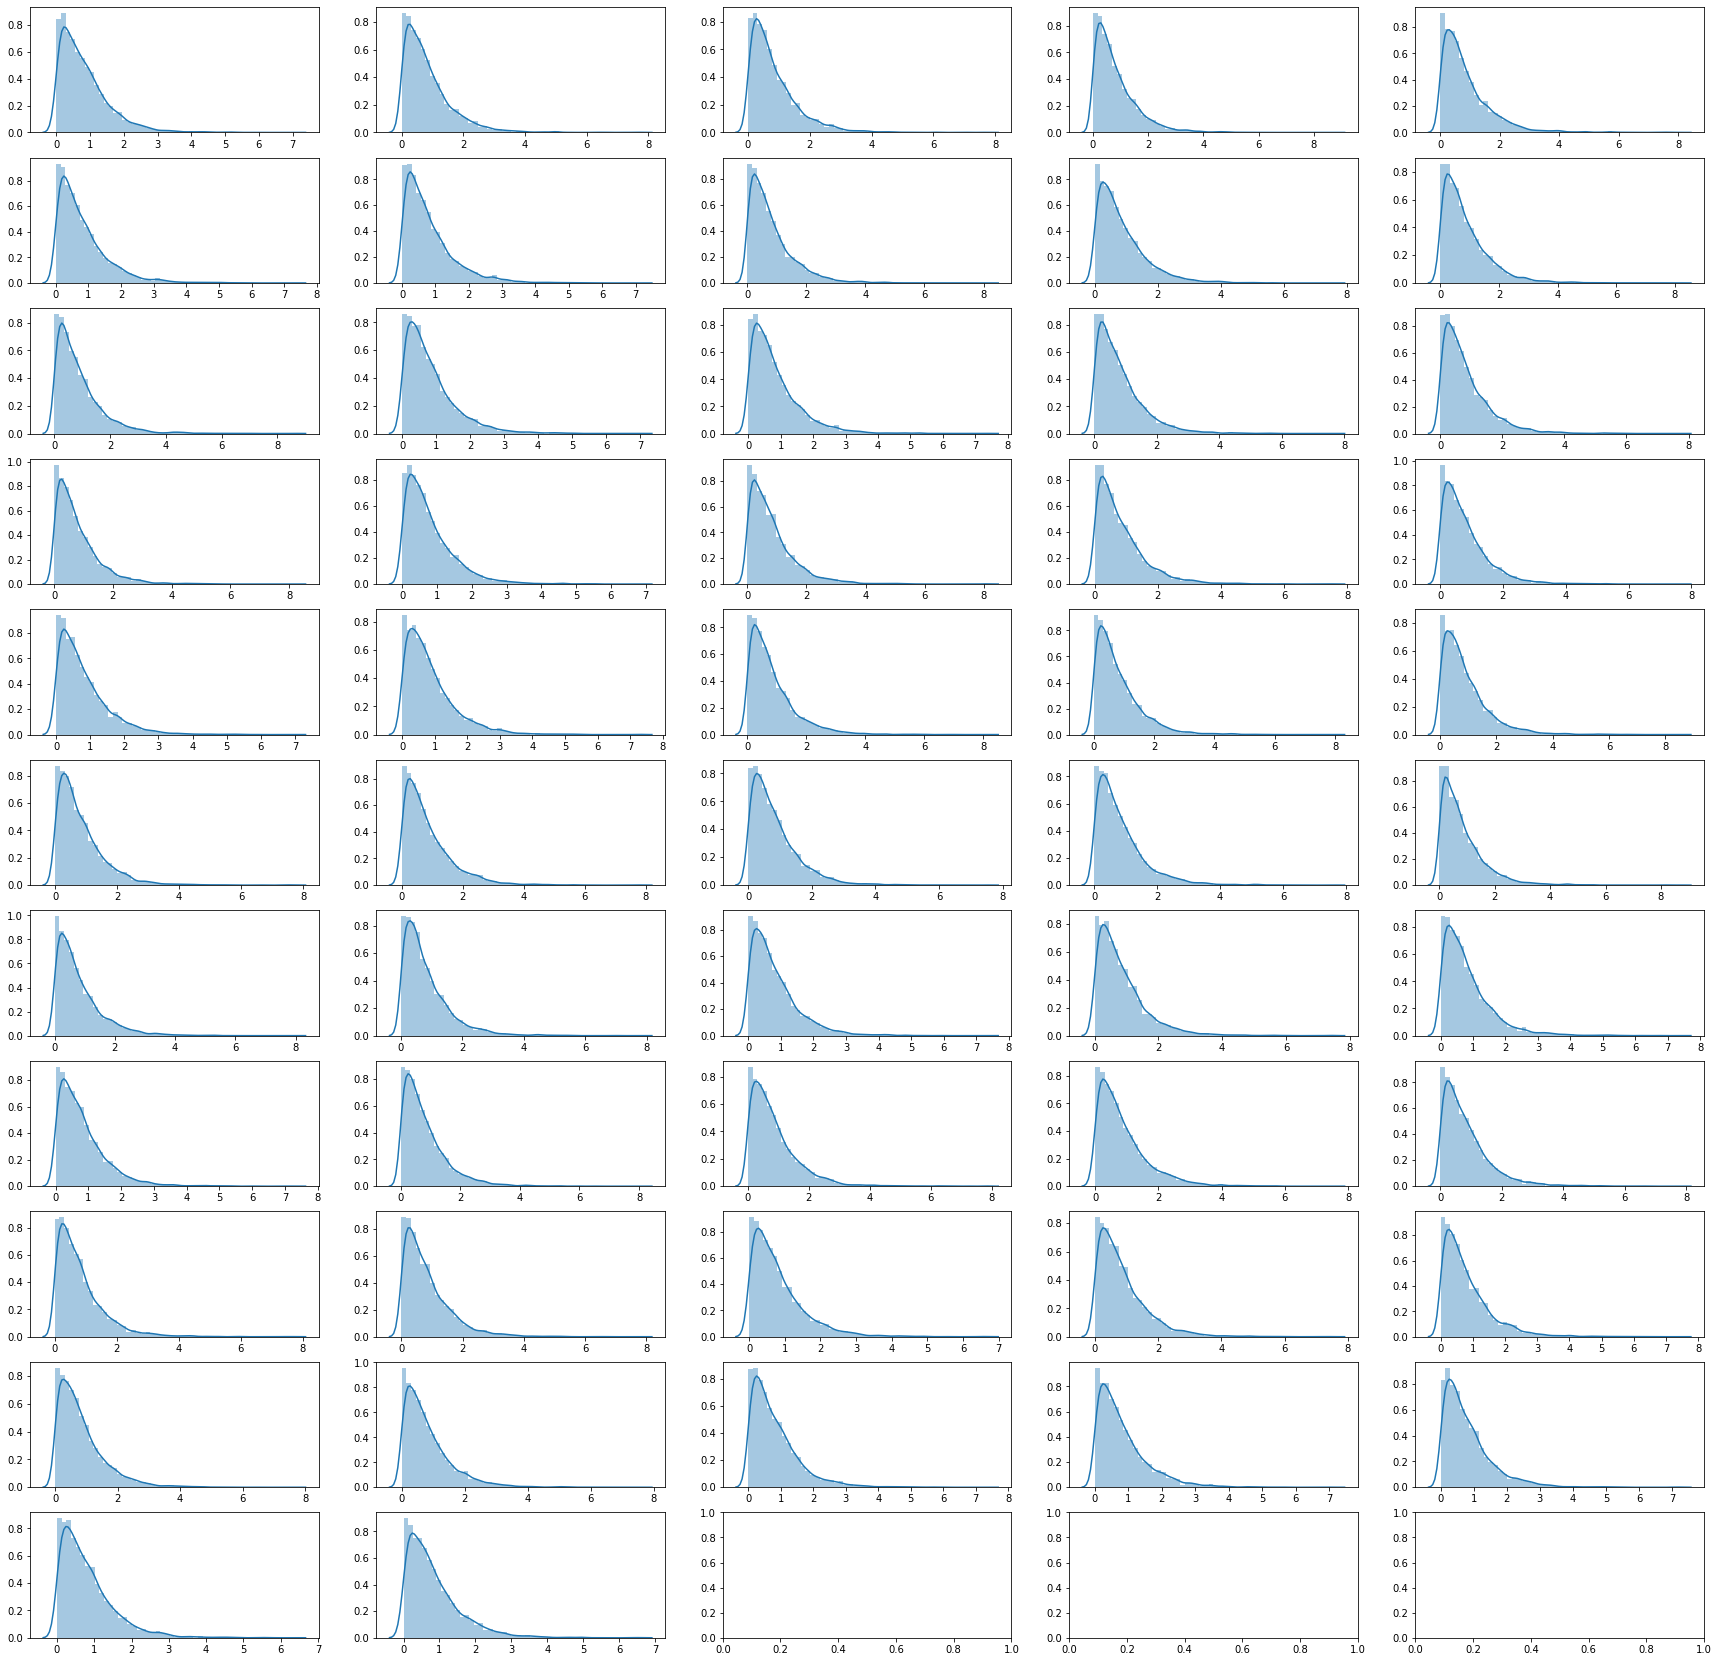

In [59]:
print('四方向')
plot_new(nonzero_resi_1)

print('八方向')
plot_new(nonzero_resi_2)

## 残差合計と残差平均をそれぞれのFPGAで計算する．

- その値をホテリング理論に適用し，異常なFPGAを見つけてみる．

----------------------------------------

## ホテリング理論再確認

1. 正規分布を仮定したデータの最尤推定を行い，平均値と分散を推定する．

2. 全てのデータに対してF統計量を求める．
   これは自由度1のカイ二乗分布で近似できるとする.
   
3. カイ二乗分布による有意水準5%の閾値で，異常かどうか判定する．

In [60]:
resi_sum_1, resi_mean_1 = summean_residual(nonzero_resi_1)
resi_sum_2, resi_mean_2 = summean_residual(nonzero_resi_2)

#### まずは散布図でデータを確認してみる．

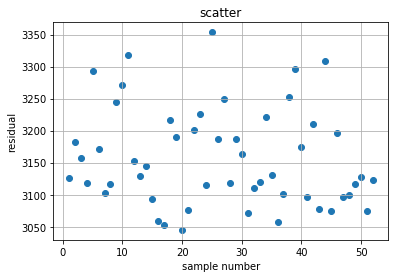

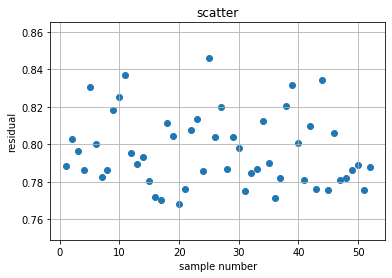

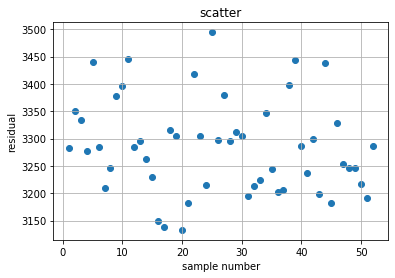

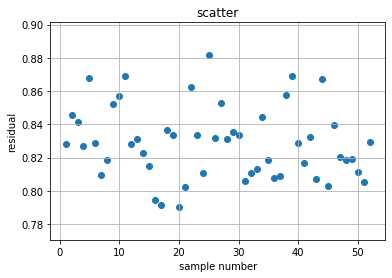

In [61]:
ten(resi_sum_1)
ten(resi_mean_1)
ten(resi_sum_2)
ten(resi_mean_2)

### 51, 52のデータを異常と判定できなさそう．．．
----------------------------------

### 次にそれぞれのデータの正規性を確認する．（ホテリング理論に適用するため）

QQプロット


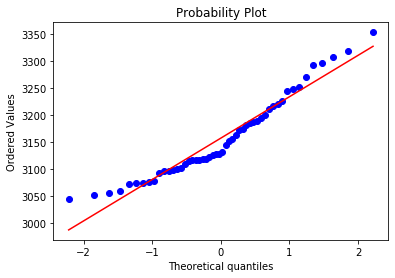

コルモゴロフスミルノフ検定0.15127205560857193
シャピロウィルク検定0.012513765133917332

QQプロット


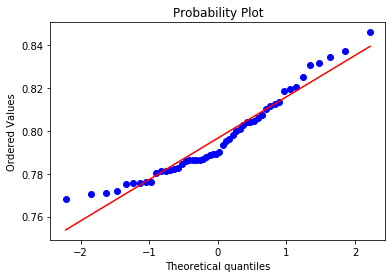

コルモゴロフスミルノフ検定0.14939347594756727
シャピロウィルク検定0.012001066468656063

QQプロット


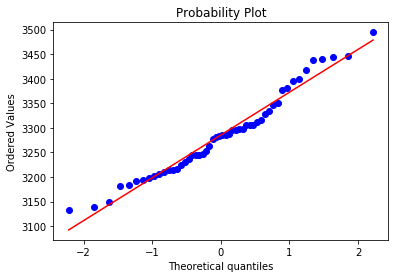

コルモゴロフスミルノフ検定0.663624999591853
シャピロウィルク検定0.15102702379226685

QQプロット


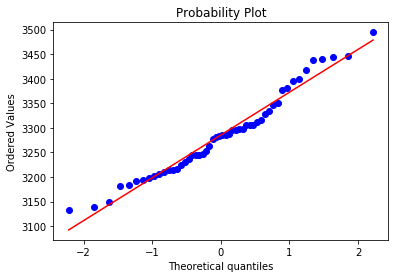

コルモゴロフスミルノフ検定0.6636249995918767
シャピロウィルク検定0.15102869272232056



In [62]:
print('QQプロット')
qq(resi_sum_1)
a = kolmogorov_smirnov(resi_sum_1)
b = shapiro_wilk(resi_sum_1)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

print('QQプロット')
qq(resi_mean_1)
a = kolmogorov_smirnov(resi_mean_1)
b = shapiro_wilk(resi_mean_1)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

print('QQプロット')
qq(resi_sum_2)
a = kolmogorov_smirnov(resi_sum_2)
b = shapiro_wilk(resi_sum_2)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

print('QQプロット')
qq(resi_sum_2)
a = kolmogorov_smirnov(resi_mean_2)
b = shapiro_wilk(resi_mean_2)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

## 検定結果

- 四方向の残差合計，残差平均は，コルモゴロフスミルノフ検定だと棄却されないが，シャピロウィルク検定だと棄却される．


- 八方向の残差合計，残差平均は，両検定共に棄却されない．

----------------------------------------------------

## ホテリング理論

- 検定結果より，八方向のみに適用するのが望ましいが，今回は数が少ないので，すべてに適用して結果を確認する．

ホテリング理論結果


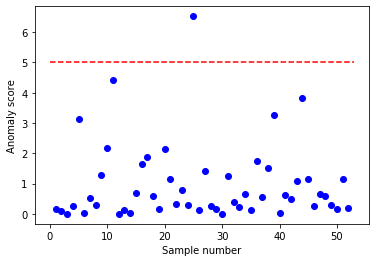

散布図


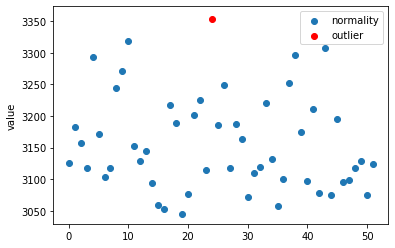

異常index：25

ホテリング理論結果


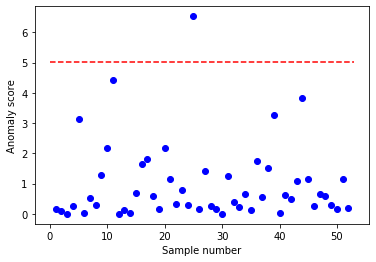

散布図


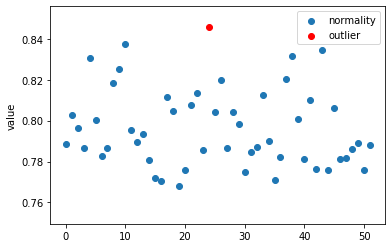

異常index：25

ホテリング理論結果


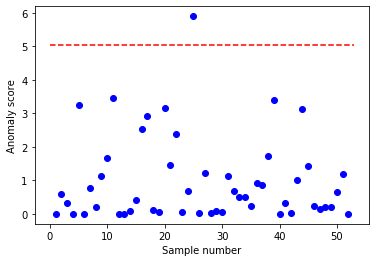

散布図


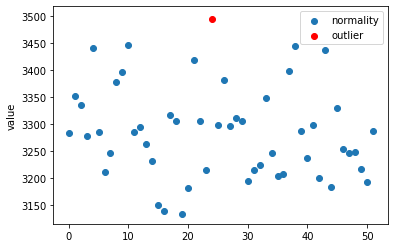

異常index：25

ホテリング理論結果


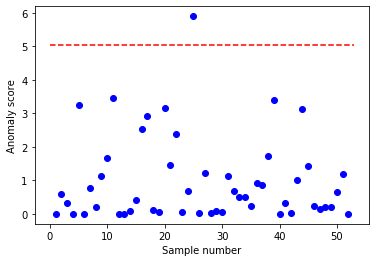

散布図


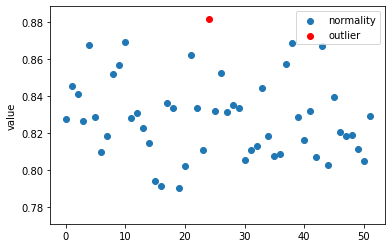

異常index：25



In [63]:
hoteling(resi_sum_1)
hoteling(resi_mean_1)
hoteling(resi_sum_2)
hoteling(resi_mean_2)

## 結果
- 51, 52のデータを異常と判定することができなかった．